## 3.1. **Linear Regression**

In [ ]:
!python -m pip install --upgrade pip
!pip3 uninstall d2l -y
!pip3 uninstall tensorflow -y
!pip3 uninstall numpy -y
!pip3 uninstall matplotlib -y
!pip3 install d2l
!pip3 install tensorflow
!pip3 install pandas==1.3.5
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 248, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to

In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

#### 3.1.1. Basics

##### 3.1.1.1 Model

선형 모델은 $\hat{y} =$ w<sup>T</sup> $x + b$ 로 나타낼 수 있다. Linear regression은 예측하려는 모델이 위와 같은 선형식을 따른다고 가정한다. 추가로, 오차들은 정규 분포를 따른다고 가정한다.

Regression Model에서 dataset $X$에 대해, 다음과 같이 쓸 수 있다. $\hat{y}$는 모델이 예측한 값이 된다.

$\hat{y} = Xw + b$

이 선형식과 라벨 $y$를 통해 Regression Model을 Fitting한다.

##### 3.1.1.2. Loss Function

Regression Model은 Loss Function에 대해 fitting하는 방향성을 가진다. 다음은 주로 쓰이는 제곱오차이다.

${l}^{(i)}(w, b) = {1 \over 2} (\hat{y}^{(i)} - {y}^{(i)})^2 $

##### 3.1.1.3. Analytic Solution

위 Loss Funtion을 최소화하는 것은 간단하게 다음 식으로 나타낼 수 있다.

$w = (X^{T}X)^{-1}X^{T}y $

##### 3.1.1.4 Minibatch Stochastic Gradient Descent

Regression을 학습하는 방법은 SGD이다. 다음과 같은 식으로 나타낼 수 있다.

$(w, b) \leftarrow (w,b) - {{\eta} \over {|𝚩|}}\sum {ϑ_{(w,b)}l^{(i)}(w,b)}$

흔히 아는 Gradient Descent와 매우 유사하다.

##### 3.1.1.5. Predictions

위 과정을 거쳐 훈련된 모델은 다음과 같이 나타낸다.

$\hat{w}^{T}x + \hat{b}$

x에 테스트 벡터를 넣어 예측값을 확인할 수 있겠다.

#### 3.1.2. Vectorization for Speed

In [ ]:
n = 10000
a = tf.ones(n)
b = tf.ones(n)
c = tf.Variable(tf.zeros(n))
t = time.time()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{time.time() - t:.5f} sec'

'27.18533 sec'

In [ ]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00166 sec'

위 코드는 벡터화의 중요성을 보여준다. c는 반복문으로 assign을 이용하여 a+b를 수행한다. 약 12초가 걸렸다. 반면 d는 벡터화하여 단순히 a+b를 수행했더니 1밀리초도 안 걸린 것을 확인할 수 있다. 벡터화를 하면 속도가 빨라진다!

#### 3.1.3. The Normal Distribution and Squared Loss

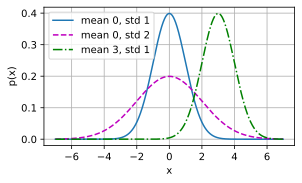

In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Linear Regression은 오차(noise)가 정규 분포를 따른다고 가정한다. 위 코드는 몇 가지 정규 분포를 시각화한 것이다. 이 정규분포를 이용하여 x값이 있을 때 특정 y값을 얻을 확률을 정규분포로 구할 수 있고, Regression Model은 이 확률을 최대화하는 방향으로 학습한다. 이 확률을 로그를 씌워 정리하면 위에서 보았던 Squared Error가 나온다. 물론 부호는 음수가 된다. 따라서 표준편차를 고정이라 하고 생각하면, 확률을 최대화하는 방향은 Loss Function을 최소화하는 방향이 된다.

## 3.2. **Object-Oriented Design for Implementation**

In [ ]:
import time
import numpy as np
import inspect
import collections
from IPython import display
import tensorflow as tf
from d2l import torch as d2l

#### 3.2.1. Utilities

In [ ]:
def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

class A:
    def __init__(self):
        self.b = 1

a = A()

@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


위 코드는 add_to_class 메소드를 이용하여 do라는 메소드를 A라는 클래스의 attribute로 추가하는 것을 보여준다.

In [ ]:
class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


In [ ]:
class ProgressBoard(HyperParameters):
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        d2l.use_svg_display()
        if self.fig is None:
            self.fig = d2l.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else d2l.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

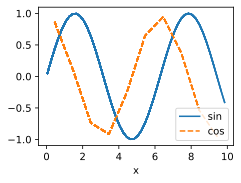

In [ ]:
board = ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)


\#@save 메소드를 코랩에서 지원하지 않아서 d2l에 저장하지 않고 구현하였다. 위 코드는 OOP를 적용하여 every_n이라는, 즉 스텝마다 그래프를 그리는 ProgressBoard 클래스를 구현하고 테스트한 것을 보여준다. save_hyperparameters는 add_to_class와 유사한 기능을 한다. NotImplemented가 포함된 메소드는 하위 클래스가 구현할 것들이다.

#### 3.2.2. Models

In [ ]:
class Module(tf.keras.Model, HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.training = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def call(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs['training']
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.numpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

class DataModule(HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.save_hyperparameters()
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

위 코드는 d2l에서 쓸 전반적인 Object들을 Object-Oriented Design을 적용하여 정의한 것이다. \#@save 메소드가 지원되지 않아서 챕터마다 이걸 쓰려면 재정의해야하는 불편함이 있지만 어쩔 수 없다.

#### Exercises

2. Remove the save_hyperparameters statement in the B class. Can you still print self.a and self.b? Optional: if you have dived into the full implementation of the HyperParameters class, can you explain why?

In [ ]:
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters()
        print('self.a =', self.a, 'self.b =', self.b)
        print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = False


위와 같이 save_hyperparameter가 없으면 attribute를 불러오지 못하는 결과를 볼 수 있다. B라는 클래스를 정의할 때 setattr가 포함된 save_hyperparameter를 이용하여 \__init__의 argument로 주어진 것들을 추가할 수 있었는데, setattr가 없으므로 attribute에 추가되지 않는다. 따라서 저 코드에서 B는 그냥 빈 껍데기가 된다.

## 3.3. **Synthetic Regression Data**

In [ ]:
%matplotlib inline
import random

#### 3.3.1. Generating the Dataset

In [ ]:
class SyntheticRegressionData(DataModule):
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1, 1))) + b + noise

In [ ]:
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tf.Tensor([-0.24148229 -0.545533  ], shape=(2,), dtype=float32) 
label: tf.Tensor([5.572041], shape=(1,), dtype=float32)


DataModule을 상속하여 Regression Model에 쓰일 수 있는 SyntheticRegressionData를 정의하고, 인스턴스를 생성한 코드이다. w,b는 Ground Truth이다. 즉 Regression Model이 학습해야 할 목표이다. 아래 print는 생성된 1000개의 데이터 중 첫 번째 데이터 쌍을 표시한 것이다. \__init__에서 볼 수 있듯이 y에 noise가 추가된 것을 확인할 수 있다.

#### 3.3.2. Reading the Dataset

In [ ]:
@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    if train:
        indices = list(range(0, self.num_train))
        # The examples are read in random order
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0, len(indices), self.batch_size):
        j = tf.constant(indices[i : i+self.batch_size])
        yield tf.gather(self.X, j), tf.gather(self.y, j)

전 절에서 구현한 add_to_class를 통해 DataModule의 get_dataloader를 구현한 코드이다. train data를 로드할 때는 위 절에서 구현한 SyntheticRegressionData에서 앞 1000개 데이터를 가져오고, test할 때에는 뒤 1000개 데이터를 가져오는 것을 확인할 수 있다.

In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


#### 3.3.3. Concise Implementation of the Data Loader

In [ ]:
@add_to_class(DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

@add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [ ]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


위 코드는 전 절의 그것과 같은 기능을 한다. 다만 이 버전은 train data를 섞는 기능도 가지고 있다.

이렇게 Object-Oriented Design으로 추상화하여 모델을 구현하는 것은 조작이 간편하고 데이터의 종류 등에 대해 유연하게 적용할 수 있다.

## 3.4. **Linear Regression Implementation from Scratch**

#### 3.4.1. Defining the Model

In [ ]:
class LinearRegressionScratch(Module):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        w = tf.random.normal((num_inputs, 1), mean=0, stddev=0.01)
        b = tf.zeros(1)
        self.w = tf.Variable(w, trainable=True)
        self.b = tf.Variable(b, trainable=True)

위 코드는 Linear Regression Model 클래스를 초기화까지 구현한 것이다. w와 b를 초기화하고, num_inputs와 learning rate, 표준편차를 argument로 받아서 attribute로 저장한다.

In [ ]:
@add_to_class(LinearRegressionScratch)
def forward(self, X):
    return tf.matmul(X, self.w) + self.b

순전파의 정의이다. 선형식을 계산할 뿐 다른 특별한 점은 없다.

#### 3.4.2. Defining the Loss Function

In [ ]:
@add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return tf.reduce_mean(l)

위 코드 역시 제곱오차로 Loss Function을 정의하였다. 차원이 여러 개인 점을 감안하여 평균을 취하고 별다른 특별한 점은 없다.

#### 3.4.3. Defining the Optimization Algorithm

In [ ]:
class SGD(HyperParameters):
    """Minibatch stochastic gradient descent."""
    def __init__(self, lr):
        self.save_hyperparameters()

    def apply_gradients(self, grads_and_vars):
        for grad, param in grads_and_vars:
            param.assign_sub(self.lr * grad)

@add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD(self.lr)

이 역시 Gradient Descent를 이용하여 최적화 알고리즘을 구현한 것이다. 특별한 점은 안 보인다.

#### 3.4.4. Training

In [ ]:
@add_to_class(Trainer)
def prepare_batch(self, batch):
    return batch

@add_to_class(Trainer)
def fit_epoch(self):
    self.model.training = True
    for batch in self.train_dataloader:
        with tf.GradientTape() as tape:
            loss = self.model.training_step(self.prepare_batch(batch))
        grads = tape.gradient(loss, self.model.trainable_variables)
        if self.gradient_clip_val > 0:
            grads = self.clip_gradients(self.gradient_clip_val, grads)
        self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.training = False
    for batch in self.val_dataloader:
        self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

Training data에 대해 epoch을 한번 도는 코드 역시 특별한 것은 보이지 않는다. training_step에 대해 loss function을 계산한 뒤, Gradient Descent로 최적화를 수행한다.

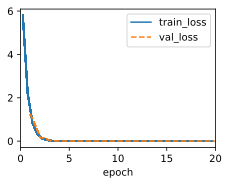

In [ ]:
model = LinearRegressionScratch(2, lr=0.03)
data = SyntheticRegressionData(w=tf.constant([0., 0.]), b=4.2)
trainer = Trainer(max_epochs=20)
trainer.fit(model, data)

In [ ]:
print(f'error in estimating w: {data.w - tf.reshape(model.w, data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: [ 4.166941e-06 -7.031124e-04]
error in estimating b: [0.00088978]


#### 3.4.6. Exercises

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 
$1,000$ rather than $0.01$?

weight를 0으로 초기화하여도 weight가 모두 0인 지점에서 Loss Function이 최소가 아닌 이상 Gradient는 0이 아니기 때문에 학습이 여전히 된다. 그리고 데이터의 표준편차를 1000으로 설정하였다면 그 데이터는 말 그대로 골고루 퍼진 형태일 것이다. 이런 형태에서 선형식을 회귀하기란 정말 애매한 부분이다. 따라서 분산을 1000으로 설정한다면 학습이 매우 어려울 것이다.

6. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

Learning Rate는 0.03에서 0.2로 조정한 결과 마지막 epoch에서 error가 확연히 줄어든 것을 확인하였다. 반대로 learning rate 0.03은 그대로 두고, epoch을 늘림으로써 역전파를 줄일 수 있다.

9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously dataset would break the optimization algorithm otherwise?

섞지 않으면 같은 데이터에 대해 반복 학습하여 오버피팅이 발생할 수 있다.

## 3.5. **Concise Implementation of Linear Regression**

#### 3.5.1. Defining the Model

Tensorflow의 keras를 통해 신경망을 간단하게 만들 수 있다.

In [ ]:
class LinearRegression(Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

output이 하나인 신경망을 Dense로 만들었다. 입력층의 shape는 지정하지 않아도 된다. keras가 알아서 할 것이기 때문이다.

In [ ]:
@add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

선형식은 퍼셉트론 순전파의 그것과 식이 완전 똑같기 때문에 Dense로 치환하여 forward를 정의할 수 있다.

#### 3.5.2. Defining the Loss Function

In [ ]:
@add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

역시 keras의 MeanSquaredError 클래스를 이용하여 Loss Function도 간편히 구현할 수 있다.

#### 3.5.3. Defining the Optimization Algorithm

In [ ]:
@add_to_class(LinearRegression)
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

최적화 알고리즘 역시 SGD 클래스로 간편하게 정의할 수 있다.

#### 3.5.4. Training

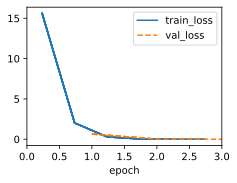

In [ ]:
model = LinearRegression(lr=0.03)
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)
trainer = Trainer(max_epochs=3)
trainer.fit(model, data)

In [ ]:
@add_to_class(LinearRegression)
def get_w_b(self):
    return (self.get_weights()[0], self.get_weights()[1])

w, b = model.get_w_b()
print(w, b)

[[ 1.994574 ]
 [-3.3914442]] [4.1887536]


우리는 Ground Truth를 $w = $\[2, -3.4], $b = $ \[4.2]로 정의하였다. 위 결과가 Ground Truth과 상당히 유사하다는 것을 확인할 수 있다.

Training 과정도 Object-Oriented Design 덕에 다른 점이 하나도 없다.

## 3.7. **Weight Decay**

In [ ]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

#### 3.7.1. Norms and Weight Decay

Weight Decay란, weight를 직접 조작하는 것이 아닌 값에 제한을 두는 방법이다. $f = 0$ 이라는, 함수의 모든 input에 0을 대입한 후 0에 대한 거리에 따라 값을 제한한다고 한다..? 사실 잘 이해를 못했다.

f(x) = $w^{T}x$ 라는 함수로 $||w||$ 와 같이 norm을 구할 수 있다. 이 값을 손실함수로 두어 최대한 0에 가깝게 하는, 즉 최소화하는 방법이 있다. Optimization 기법은 전과 같다.

#### 3.7.2. High-Dimensional Linear Regression

Weight Decay를 이용한 Regression Model 구현

In [ ]:
class Data(DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, num_inputs))
        noise = tf.random.normal((n, 1)) * 0.01
        w, b = tf.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = tf.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [ ]:
def l2_penalty(w):
    return tf.reduce_sum(w**2) / 2

${l}_{2}$ norm을 Loss Function으로 쓸 것이다.

In [ ]:
class WeightDecayScratch(LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

lambda 가중치와 함께 ${l}_{2}$ norm penalty가 Loss Function에 쓰인 것을 확인할 수 있다.

L2 norm of w: 0.009729718789458275


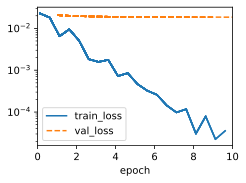

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))
train_scratch(0)

lambda에 0을 대입하면 오버피팅이 일어나는 것을 확인할 수 있다.

L2 norm of w: 0.00133259198628366


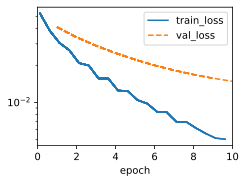

In [ ]:
train_scratch(3)

lambda에 non-zero value를 부여함으로써 Weight Decay를 활성화하였다.

#### 3.7.4. Concise Implementation

늘 해왔던 대로 라이브러리를 이용하여 코드를 간결화한다.

In [ ]:
class WeightDecay(LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = tf.keras.layers.Dense(
            1, kernel_regularizer=tf.keras.regularizers.l2(wd),
            kernel_initializer=tf.keras.initializers.RandomNormal(0, 0.01)
        )

    def loss(self, y_hat, y):
        return super().loss(y_hat, y) + self.net.losses

L2 norm of w: 0.0005930731422267854


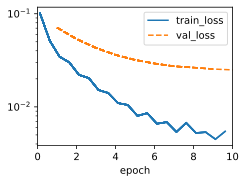

In [ ]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

#### Exercises

1. Experiment with the value of $𝛌$ in the estimation problem in this section. Plot training and validation accuracy as a function of $𝛌$. What do you observe?

L2 norm of w: 0.00639332365244627


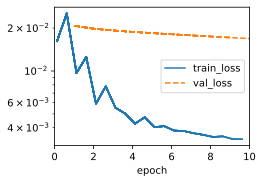

In [ ]:
train_scratch(0.5)

L2 norm of w: 0.004502885974943638


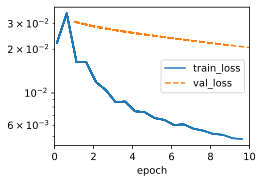

In [ ]:
train_scratch(1)

L2 norm of w: 0.002220424823462963


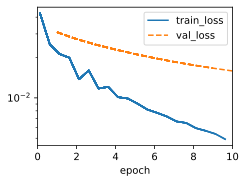

In [ ]:
train_scratch(2)

L2 norm of w: 0.0005095232627354562


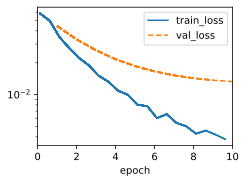

In [ ]:
train_scratch(5)

L2 norm of w: 0.00020613439846783876


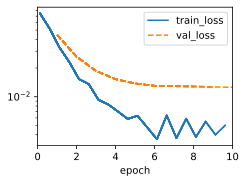

In [ ]:
train_scratch(10)

L2 norm of w: 8.870750025380403e-05


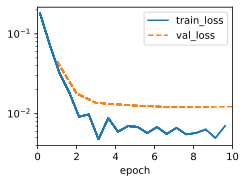

In [ ]:
train_scratch(20)

람다 값이 10, 20,처럼 너무 크다면 오버피팅이 일어나는 것을 확인했다. 적당한 값은 2에서 5 사이인 것 같다.